# architecture-30 ( Basic Classification ) w-3

## What's new:

1- Without RSI

2- add labels only start and end of trends.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, TimeDistributed, Lambda
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import talib
from sklearn.utils.class_weight import compute_class_weight


In [2]:
# 1- Load and Scaling Features
df = pd.read_csv('datasets-30/XAGUSD-H1-rates.csv', sep='\t')

# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Combine DATE and TIME into a single datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

# Drop rows with missing values
df.dropna(inplace=True)

# Sort data chronologically by DATETIME
df.sort_values(by='DATETIME', inplace=True)

# Reset index to ensure clean row order
df.reset_index(drop=True, inplace=True)

# Select features to scale
FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Initial scaling (later corrected to avoid leakage)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[FEATURES])

In [3]:
# 2- Label trend reversals (example: a simplistic method)

df['RSI'] = talib.RSI(df['CLOSE'].values, timeperiod=14)

labels = np.zeros(len(df), dtype=int)

# Buy when RSI crosses up through 30, Sell when RSI crosses down through 70
for i in range(1, len(df['RSI'])):
    if df['RSI'].iloc[i - 1] < 30 and df['RSI'].iloc[i] >= 30:
        labels[i] = 1  # Buy
    elif df['RSI'].iloc[i - 1] > 70 and df['RSI'].iloc[i] <= 70:
        labels[i] = 2  # Sell
    else:
        labels[i] = 0  # No signal

df['Label'] = labels

In [4]:
def plot_labeled_candles(df, n=150):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    """
    # Use only the last n rows
    df_plot = df.tail(n).copy()
    df_plot['DATETIME'] = df_plot['DATE'] + ' ' + df_plot['TIME']

    # Plot the closing price
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # Plot BUY (label=1) and SELL (label=2) signals
    for idx, row in df_plot.iterrows():
        if row['Label'] == 1:
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()

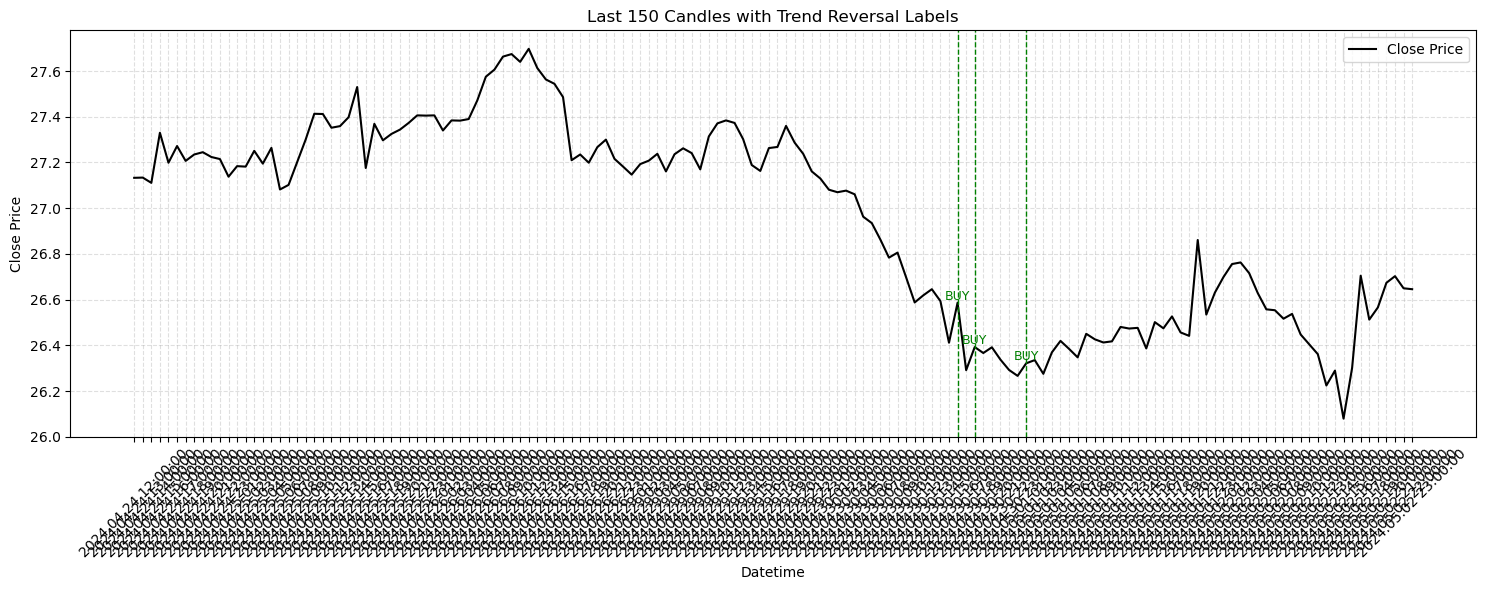

In [5]:
plot_labeled_candles(df)

In [6]:
# ================================================================
# 3- Prepare Sequences
# ================================================================
SEQUENCE_LENGTH = 60
FORECAST_HORIZON = 10
GAP = SEQUENCE_LENGTH + FORECAST_HORIZON

last_anchor = len(df) - FORECAST_HORIZON
anchors = np.arange(SEQUENCE_LENGTH, last_anchor)
N = len(anchors)

if N <= 3 * GAP + 10:
    raise ValueError("Dataset too small for safe time-based splits with the chosen GAP.")

In [7]:
# ================================================================
# 4- Split dataset (time-based with embargo)
# ================================================================
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.8, 0.1, 0.1
N_eff = N - 2 * GAP
train_count = int(N_eff * TRAIN_RATIO)
val_count   = int(N_eff * VAL_RATIO)
test_count  = N_eff - train_count - val_count

train_end = train_count
val_start = train_end + GAP
val_end   = val_start + val_count
test_start = val_end + GAP
test_end   = test_start + test_count

assert test_end <= N and train_end > 0 and val_end > val_start and test_end > test_start, \
       "Bad split boundaries—check dataset size and ratios."

In [8]:
# ================================================================
# 5- Scaling without leakage
# ================================================================
train_cut_row = int(anchors[train_end - 1])
scaler = MinMaxScaler()
scaler.fit(df.loc[:train_cut_row - 1, FEATURES])
scaled_all = scaler.transform(df[FEATURES].values)


/home/saeed/repositories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [9]:
# ================================================================
# 6- Build sequences (X, y)
# ================================================================
def build_xy_from_anchors(scaled_feats, labels, anchor_indices, seq_len, horizon):
    X_list, y_list = [], []
    for i in anchor_indices:
        X_list.append(scaled_feats[i - seq_len:i])         # (seq_len, n_features)
        y_list.append(labels[i:i + horizon])               # (horizon,)
    return np.array(X_list), np.array(y_list)

X_all, y_all = build_xy_from_anchors(
    scaled_all, df['Label'].values, anchors, SEQUENCE_LENGTH, FORECAST_HORIZON
)

In [10]:
# ================================================================
# 7- Final train/val/test split + one-hot encoding
# ================================================================
X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val,   y_val   = X_all[val_start:val_end], y_all[val_start:val_end]
X_test,  y_test  = X_all[test_start:test_end], y_all[test_start:test_end]

# One-hot encode
y_train_onehot = np.array([to_categorical(seq, num_classes=3) for seq in y_train])
y_val_onehot   = np.array([to_categorical(seq, num_classes=3) for seq in y_val])
y_test_onehot  = np.array([to_categorical(seq, num_classes=3) for seq in y_test])

print(f"Samples -> train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")

Samples -> train: 43898, val: 5487, test: 5488


In [13]:
# ================================================================
# 8- Define LSTM classification model
# ================================================================
model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(64, activation='relu')),
    TimeDistributed(Dense(3, activation='softmax')),
    Lambda(lambda x: x[:, -FORECAST_HORIZON:, :])  # last horizon steps
])


In [16]:

import tensorflow.keras.backend as K

# build class weights manually (from flat labels)
flat_y = y_train.flatten()
class_weights_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(flat_y),
    y=flat_y
)
class_weights = {i: w for i, w in enumerate(class_weights_vals)}
print("Class Weights:", class_weights)

def weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # y_true, y_pred shape: (batch, horizon, num_classes)
        weights = K.constant([class_weights[i] for i in range(len(class_weights))])
        # multiply each class probability by its weight
        y_true_weights = K.sum(y_true * weights, axis=-1)  # shape (batch, horizon)
        unweighted_loss = K.categorical_crossentropy(y_true, y_pred)
        return unweighted_loss * y_true_weights
    return loss

# Compile with custom loss
model.compile(
    optimizer='adam',
    loss=weighted_categorical_crossentropy(class_weights),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')
    ]
)

# Now fit WITHOUT class_weight argument
history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_val, y_val_onehot),
    epochs=50,
    batch_size=64,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

Class Weights: {0: np.float64(0.34306944698436814), 1: np.float64(23.987978142076503), 2: np.float64(23.01457481388277)}
Epoch 1/50


I0000 00:00:1755455249.965912    3483 cuda_dnn.cc:529] Loaded cuDNN version 91001


686/686 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.2489 - loss: 1.1126 - top_2_accuracy: 0.7333 - val_accuracy: 0.9712 - val_loss: 1.1094 - val_top_2_accuracy: 0.9854
Epoch 2/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.3551 - loss: 1.1070 - top_2_accuracy: 0.7059 - val_accuracy: 0.9712 - val_loss: 1.1098 - val_top_2_accuracy: 0.9854
Epoch 3/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.4344 - loss: 1.1068 - top_2_accuracy: 0.7372 - val_accuracy: 0.9712 - val_loss: 1.1095 - val_top_2_accuracy: 0.9854
Epoch 4/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5956 - loss: 1.1068 - top_2_accuracy: 0.7506 - val_accuracy: 0.9712 - val_loss: 1.1095 - val_top_2_accuracy: 0.9854
Epoch 5/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.3716 - loss: 1.1068 - top_2_accuracy: 0.7135 - val_accuracy: 0.9712 - val_loss: 1.1095 - val_top_2_accuracy: 0.9854
Epoch 6/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.6252 - loss: 1.1065 - t

In [17]:
# ================================================================
# 10- Evaluate on test set
# ================================================================
final_test_loss, final_test_acc, final_test_top2 = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"Final Test  - Loss: {final_test_loss:.6f} | Acc: {final_test_acc:.6f} | Top-2: {final_test_top2:.6f}")

Final Test  - Loss: 1.226109 | Acc: 0.966655 | Top-2: 0.982872


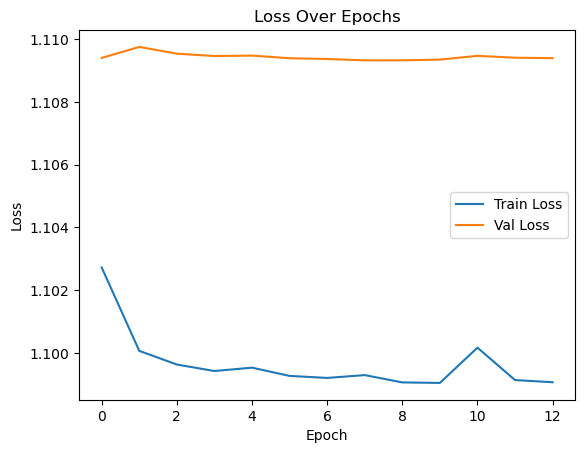

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
# 9- Load the last 60 candles from a CSV file

# Load and clean
input_df = pd.read_csv('datasets-30/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv', sep='\t')
input_df.dropna(inplace=True)

input_df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Add datetime
input_df['DATETIME'] = pd.to_datetime(input_df['DATE'] + ' ' + input_df['TIME'])

# Scale
input_features = input_df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']]
input_scaled = scaler.transform(input_features)
input_sequence = np.expand_dims(input_scaled, axis=0)  # (1, 60, 5)

# Predict
pred_probs = model.predict(input_sequence)  # shape: (1, 10, 3)
pred_classes = np.argmax(pred_probs[0], axis=1)
print("Predicted Classes:", pred_classes)  # 0=no signal, 1=buy, 2=sell

# Timestamps for forecast
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                                   periods=FORECAST_HORIZON, freq='h')

# Output DataFrame
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

print(predicted_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
Predicted Classes: [0 0 0 0 0 0 0 0 0 0]
             DATETIME  forecast_class label
0 2024-05-07 15:00:00               0      
1 2024-05-07 16:00:00               0      
2 2024-05-07 17:00:00               0      
3 2024-05-07 18:00:00               0      
4 2024-05-07 19:00:00               0      
5 2024-05-07 20:00:00               0      
6 2024-05-07 21:00:00               0      
7 2024-05-07 22:00:00               0      
8 2024-05-07 23:00:00               0      
9 2024-05-08 00:00:00               0      


# plot section

In [21]:
# 10- Plot section

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os
import pandas as pd

# 10-1 PARAMETERS
csv1_path = 'datasets-30/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-30/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Write a suitable title.'
output_plot_path = None  # e.g., 'output.png'

# 10-2 LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None
# 10-3 Generate forecast timestamps ===
# Start 1 hour after the last actual candle
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=FORECAST_HORIZON, freq='h')

# 10-4 Create predicted_df with forecasted trend reversals
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})


# 10-5 Optional: Add labels for plotting
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None


predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


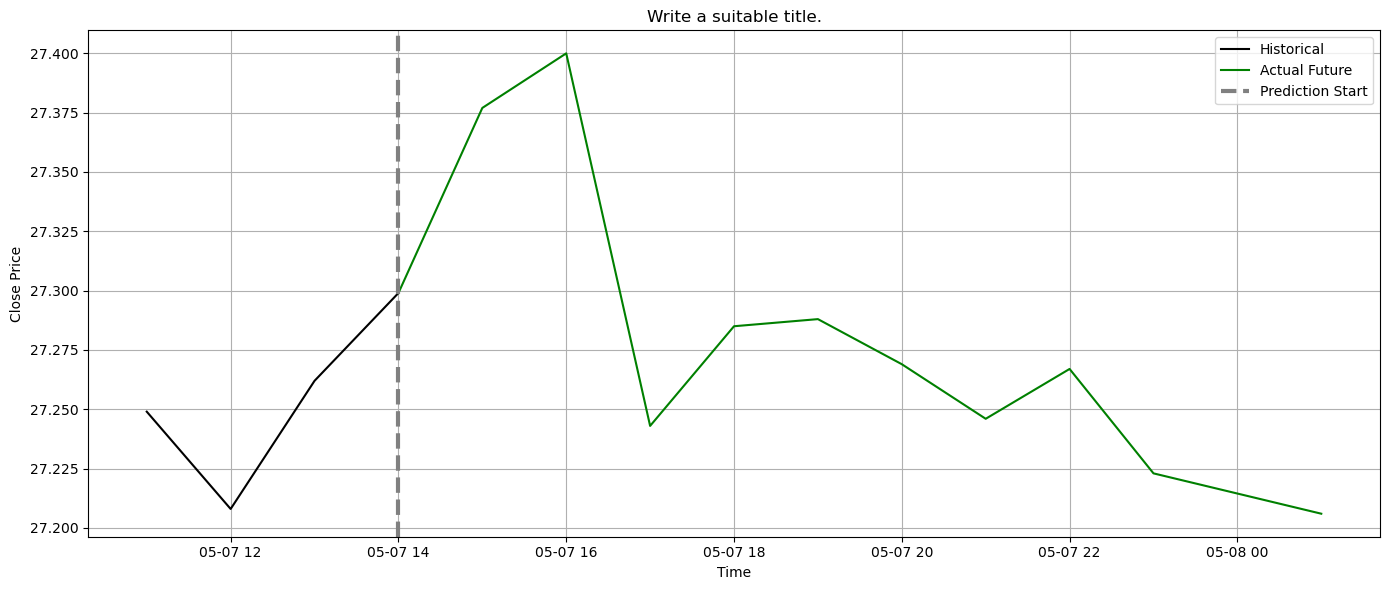

In [22]:
# 10-6 PLOT

forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [23]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-6 Save model summary and final performance
y_test_onehot = to_categorical(y_test, num_classes=3)

with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_accuracy, final_test_mae = model.evaluate(X_test, y_test_onehot, verbose=0)

    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test Accuracy: {final_test_accuracy:.6f}\n')